<a href="https://colab.research.google.com/github/SERVIR/RX_fires/blob/main/OBIWAN_Rx_Fire_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.7 MB/s eta 0:00:00


In [2]:
import pandas as pd

In [3]:
import ee
import geemap

In [4]:
# Authenticate and initialize Earth Engine
import ee
import geemap
import geemap.chart as chart
ee.Authenticate()
ee.Initialize(project='servir-sco-assets')
Map = geemap.Map()

# ESA_CCI_AGB approach

In [5]:
palette = ["#C6ECAE","#A1D490","#7CB970","#57A751","#348E32",
           "#267A29","#176520","#0C4E15","#07320D","#031807"]

# Create a map
Map = geemap.Map(center=[0, 0], zoom=2)

# Load AGB ImageCollection
agb = ee.ImageCollection('projects/sat-io/open-datasets/ESA/ESA_CCI_AGB')

# Add 2020 AGB layer
agb_2020 = agb.filterDate('2019-01-01', '2021-01-01').first().select(['AGB'])
Map.addLayer(agb_2020, {'min':1, 'max':450, 'palette': palette}, 'Above Ground Biomass 2020')


EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')

# print("EIA_CS1:", EIA_CS1.size().getInfo())
# print("EIA_CS2:", EIA_CS2.size().getInfo())
# print("EIA_CS3:", EIA_CS3.size().getInfo())

Map.addLayer(EIA_CS1, {}, "EIA_CS1")
Map.addLayer(EIA_CS2, {}, "EIA_CS2")
Map.addLayer(EIA_CS3, {}, "EIA_CS3")

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

https://gee-community-catalog.org/projects/cci_agb/
Above ground biomass (AGB, unit: tons/ha i.e., Mg/ha) (raster dataset).
This is defined as the mass, expressed as oven-dry weight of the woody parts (stem, bark, branches and twigs)
of all living trees excluding stump and roots

In [6]:
# Compute pixel area in hectares
pixel_area_ha = ee.Image.pixelArea().divide(10000)

# Biomass in Mg (tons) per pixel for 2019
agb_2019 = agb.filterDate('2019-01-01', '2019-01-02').first().select(['AGB'])

# Get projection info
proj = agb_2019.projection()
# print('Projection:', proj.getInfo())
# print('Nominal scale (m):', proj.nominalScale().getInfo())

# Multiply by pixel area to get Mg per pixel
agb_Mg_per_pixel = agb_2019.multiply(pixel_area_ha)

# Convert Mg to short tons
agb_tons_per_pixel = agb_Mg_per_pixel.multiply(1.10231)

In [7]:
# #https://gee-community-catalog.org/projects/cci_agb/
# # Above ground biomass (AGB, unit: tons/ha i.e., Mg/ha) (raster dataset).
# # This is defined as the mass, expressed as oven-dry weight of the woody parts (stem, bark, branches and twigs)
# #of all living trees excluding stump and roots

# # Compute pixel area in hectares
# pixel_area_ha = ee.Image.pixelArea().divide(10000)

# # Biomass in Mg (tons) per pixel for 2019
# agb_2019 = agb.filterDate('2019-01-01', '2019-01-02').first().select(['AGB'])

# # Get projection info
# proj = agb_2019.projection()
# # print('Projection:', proj.getInfo())
# # print('Nominal scale (m):', proj.nominalScale().getInfo())

# # Multiply by pixel area to get Mg per pixel
# agb_Mg_per_pixel = agb_2019.multiply(pixel_area_ha)

# # Convert Mg to short tons
# agb_tons_per_pixel = agb_Mg_per_pixel.multiply(1.10231)

# # Function to sum biomass per polygon
# # def add_total_biomass(fc, name):
# #     reduced = agb_tons_per_pixel.reduceRegions(
# #         collection=fc,
# #         reducer=ee.Reducer.sum(),
# #         scale=100
# #     )
# #     reduced = reduced.map(lambda f: f.set({
# #         'Source': name,
# #         'Total_AGB_tons': f.get('sum')
# #     }))
# #     return reduced


# def add_total_biomass(fc, name):
#     reduced = agb_tons_per_pixel.reduceRegions(
#         collection=fc,
#         reducer=ee.Reducer.sum(),
#         scale=100
#     )

#     # Map over features to calculate area and agb_per_acre
#     def add_attributes(f):
#         area_m2 = f.geometry().area()
#         area_acres = area_m2.divide(4046.86)
#         agb_sum = ee.Number(f.get('sum'))
#         return f.set({
#             'Source': name,
#             'Total_AGB_tons': agb_sum,
#             'agb_per_acre': agb_sum.divide(area_acres)
#         })

#     reduced = reduced.map(add_attributes)
#     return reduced







# # Apply function to feature collections
# results1 = add_total_biomass(EIA_CS1, 'EIA_CS1')
# results2 = add_total_biomass(EIA_CS2, 'EIA_CS2')
# results3 = add_total_biomass(EIA_CS3, 'EIA_CS3')

# # Merge results
# # all_results = results1.merge(results2).merge(results3)

# # print('All Results with total biomass (tons):', all_results.size().getInfo())

# # # Export to Google Drive
# # task = ee.batch.Export.table.toDrive(
# #     collection=all_results,
# #     description='EIA_AGB_total_tons_2019',
# #     fileFormat='CSV'
# # )
# # task.start()

# # Display the map
# # Map


agd and std per acre

In [8]:
def add_total_biomass(fc, name):
    # Use sum + mean + stdDev reducers
    reducer = (ee.Reducer.sum().setOutputs(['AGB_sum'])
               .combine(ee.Reducer.mean().setOutputs(['AGB_mean']), sharedInputs=True)
               .combine(ee.Reducer.stdDev().setOutputs(['AGB_stdDev']), sharedInputs=True))

    reduced = agb_tons_per_pixel.reduceRegions(
        collection=fc,
        reducer=reducer,
        scale=100
    )

    def add_attributes(f):
        area_m2 = f.geometry().area()
        area_acres = area_m2.divide(4046.86)
        agb_sum = ee.Number(f.get('AGB_sum'))
        agb_std = ee.Number(f.get('AGB_stdDev'))

        agb_per_acre = agb_sum.divide(area_acres)
        agb_std_per_acre = agb_std.divide(area_acres)

        return f.set({
            'Source': name,
            'Total_AGB_tons': agb_sum,
            'agb_per_acre': agb_per_acre,
            'stdDev_AGB_tons_per_pixel': agb_std,
            'stdDev_AGB_per_acre': agb_std_per_acre
        })

    return reduced.map(add_attributes)


In [9]:
# Apply function to feature collections
results1 = add_total_biomass(EIA_CS1, 'EIA_CS1')
results2 = add_total_biomass(EIA_CS2, 'EIA_CS2')
results3 = add_total_biomass(EIA_CS3, 'EIA_CS3')

# Merge them
all_results = results1.merge(results2).merge(results3)

# # Inspect one feature
# print(all_results.first().toDictionary().getInfo())

In [10]:
all_results

In [11]:
# Convert to GeoPandas GeoDataFrame
gdf = geemap.ee_to_gdf(all_results)

# Display the head of the GeoDataFrame
print(gdf.head())
# You can also plot the GeoDataFrame
# gdf.plot()
gdf["Method"] = "ESA"

                                            geometry  ACCURACY    AGB_mean  \
0  POLYGON ((-87.49023 32.99817, -87.49002 32.998...       0.0  162.472710   
1  POLYGON ((-86.96387 32.77259, -86.96354 32.769...       NaN  141.461046   
2  POLYGON ((-87.34536 32.97872, -87.34433 32.978...      12.0  136.080635   

   AGB_stdDev        AGB_sum   CN COMMENTS COMPLEXNAM DATASOURCE  \
0   70.580626  100039.226140                                  02   
1   58.788998  182540.223686                                  02   
2   84.818146   67667.296514  NaN      NaN        NaN        NaN   

     DBSOURCEDA  ... STATE_ABBR  SUBUNIT                 SUID       SUID_CN  \
0  1.750576e+12  ...        NaN      NaN                  NaN           NaN   
1  1.750921e+12  ...        NaN      NaN                  NaN           NaN   
2           NaN  ...         AL      001  0801041111001200001  888441010602   

  TREATMENT1      TREATMENT_                UK  \
0        NaN             NaN               NaN 

In [12]:
print(gdf.columns.tolist())


['geometry', 'ACCURACY', 'AGB_mean', 'AGB_stdDev', 'AGB_sum', 'CN', 'COMMENTS', 'COMPLEXNAM', 'DATASOURCE', 'DBSOURCEDA', 'DBSOURCEID', 'DISCOVERYD', 'FEATURECAT', 'FID_S_USA_', 'FIRENAME', 'FIREOCCURI', 'FIRERPTQC', 'FIREYEAR', 'GISACRES', 'GLOBALID', 'LOCALFIREN', 'NAME', 'OWNERAGENC', 'PROTECTION', 'REVDATE', 'SECURITYID', 'SIZECLASS', 'SOFIRENUM', 'STATCAUSE', 'STUSPS', 'Shape_Area', 'Shape_Le_1', 'Shape_Leng', 'Source', 'TOTALACRES', 'Total_AGB_tons', 'UNIQFIREID', 'UNITIDOWNE', 'UNITIDPROT', 'agb_per_acre', 'stdDev_AGB_per_acre', 'stdDev_AGB_tons_per_pixel', 'OBJECTID', 'SHAPEAREA', 'SHAPELEN', 'ACCOMPLISH', 'ACCOMPLI_1', 'ACTIVITY', 'ACTIVITY_1', 'ACTIVITY_2', 'ACTIVITY_C', 'ACTIVITY_S', 'ACTIVITY_U', 'ACT_CREATE', 'ACT_MODIFI', 'ADMIN_DIST', 'ADMIN_FORE', 'ADMIN_REGI', 'ASPECT', 'ASU_NBR_UN', 'ASU_UOM', 'CAT_NM', 'COST_PER_U', 'CRC_HAZ', 'CRC_VALUE', 'CWPP', 'DATA_SOURC', 'DATA_SOU_1', 'DATE_AWARD', 'DATE_COMPL', 'DATE_PLANN', 'EDW_INSERT', 'ELEVATION', 'EQUIPMENT', 'EQUIPMENT_

In [13]:
gdf

,geometry,ACCURACY,AGB_mean,AGB_stdDev,AGB_sum,CN,COMMENTS,COMPLEXNAM,DATASOURCE,DBSOURCEDA,...,SUBUNIT,SUID,SUID_CN,TREATMENT1,TREATMENT_,UK,UK_HAZ,UOM,WORKFORCE_,Method
0,"POLYGON ((-87.49023 32.99817, -87.49002 32.998...",0.0,162.472710,70.580626,100039.226140,,,,02,1.750576e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESA
1,"POLYGON ((-86.96387 32.77259, -86.96354 32.769...",NaN,141.461046,58.788998,182540.223686,,,,02,1.750921e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESA
2,"POLYGON ((-87.34536 32.97872, -87.34433 32.978...",12.0,136.080635,84.818146,67667.296514,NaN,NaN,NaN,NaN,NaN,...,001,0801041111001200001,888441010602,,Broadcast Burn,0801_169923_ACTP,5813775010602_0801041111001200001,ACRES,FA,ESA


In [14]:
# import matplotlib.pyplot as plt

# # Aggregate total AGB by Source
# agg = gdf.groupby("Source")["agb_per_acre"].sum().reset_index()

# # Bar chart
# plt.figure(figsize=(10,6))
# plt.bar(agg["Source"], agg["agb_per_acre"], color="pink", edgecolor="black")

# plt.xlabel("Source")
# plt.ylabel("Total AGB (tons)")
# plt.title("Total AGB by Source")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


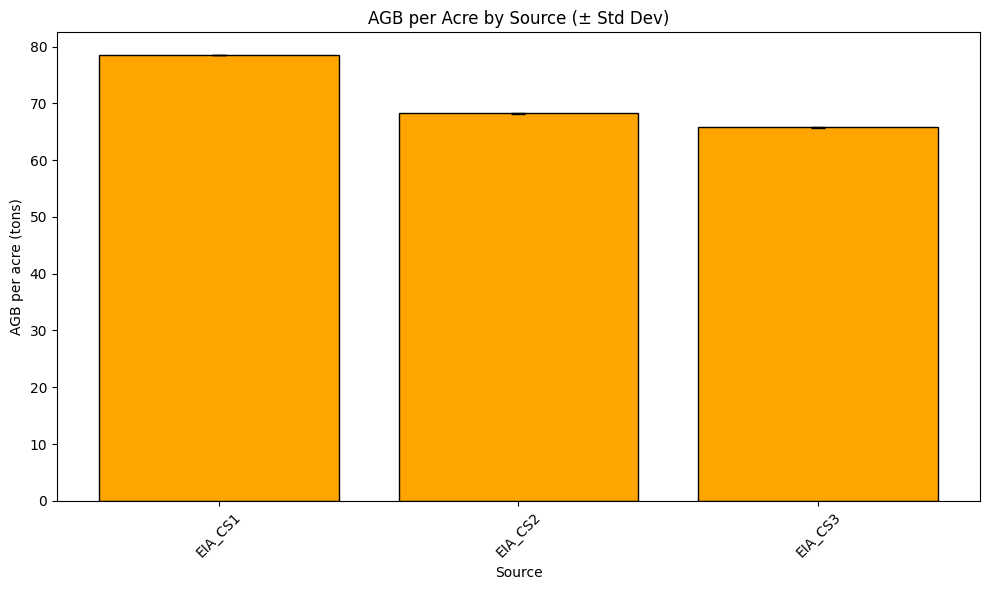

In [15]:
import matplotlib.pyplot as plt

# Aggregate mean and stdDev by Source
agg = gdf.groupby("Source").agg(
    mean_agb_per_acre=("agb_per_acre", "mean"),
    std_agb_per_acre=("stdDev_AGB_per_acre", "mean")  # or "std" if you want across-polygons variability
).reset_index()

# Bar chart with error bars
plt.figure(figsize=(10,6))
plt.bar(
    agg["Source"],
    agg["mean_agb_per_acre"],
    yerr=agg["std_agb_per_acre"],
    capsize=5,
    color="orange",
    edgecolor="black"
)

plt.xlabel("Source")
plt.ylabel("AGB per acre (tons)")
plt.title("AGB per Acre by Source (± Std Dev)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# OBIWAN approach

In [16]:
import ee, json


# Your FeatureCollections
EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')

# Convert to GeoJSON (Python dicts)
geojson_fc1 = EIA_CS1.getInfo()
geojson_fc2 = EIA_CS2.getInfo()
geojson_fc3 = EIA_CS3.getInfo()


In [17]:
import requests

class ObiwanClient:
    def __init__(self, base_url="https://obiwan-alabama-api-5026633953.us-west1.run.app"):
        self.base_url = base_url.rstrip('/')

    def estimate_biomass_stock(self, year, geojson_payload, calibration_flag=False):
        # New endpoint (shorter path)
        endpoint = f"{self.base_url}/estimate_biomass_state_geojson/{year}"
        params = {"use_calibration": str(calibration_flag).lower()}  # true/false
        headers = {"Content-Type": "application/json"}

        response = requests.post(endpoint, params=params, json=geojson_payload, headers=headers)
        response.raise_for_status()
        return response.json()


In [18]:
client = ObiwanClient()

year = 2019
calibration_flag = True  # or True

In [19]:
# estimates_fc1 = client.estimate_biomass_stock(year, geojson_fc1, calibration_flag)
# # estimates_fc2 = client.estimate_biomass_stock(year, geojson_fc2, calibration_flag)
# # estimates_fc3 = client.estimate_biomass_stock(year, geojson_fc3, calibration_flag)
# print(estimates_fc1)
# # pd.DataFrame([estimates_fc1])
# # pd.DataFrame([estimates_fc2])
# # pd.DataFrame([estimates_fc3])

In [20]:
estimates_fc1 = client.estimate_biomass_stock(year, geojson_fc1, calibration_flag)
print(estimates_fc1)

{'AGBD': 201.2545406801871, 'area': 5152478.115234375, 'asset_version': '1.0', 'stdAGBD': 2.620773988024994, 'use_calibration': True, 'year': 2019}


In [21]:
estimates_fc2 = client.estimate_biomass_stock(year, geojson_fc2, calibration_flag)
print(estimates_fc2)

{'AGBD': 198.77709747704773, 'area': 10821259.333984375, 'asset_version': '1.0', 'stdAGBD': 3.0370967908580146, 'use_calibration': True, 'year': 2019}


In [22]:
estimates_fc3 = client.estimate_biomass_stock(year, geojson_fc3, calibration_flag)
print(estimates_fc2)

{'AGBD': 198.77709747704773, 'area': 10821259.333984375, 'asset_version': '1.0', 'stdAGBD': 3.0370967908580146, 'use_calibration': True, 'year': 2019}


In [23]:
df1 = pd.DataFrame([estimates_fc1])#.insert(1,"Source",["EIA_CS1"])
df1["Source"] = "EIA_CS1"
df1["Method"] = "OBIWAN"
df2 = pd.DataFrame([estimates_fc2])#.insert(1,"Source",["EIA_CS2"])
df2["Source"] = "EIA_CS2"
df2["Method"] = "OBIWAN"
df3 = pd.DataFrame([estimates_fc3])#.insert(1,"Source",["EIA_CS3"])
df3["Source"] = "EIA_CS3"
df3["Method"] = "OBIWAN"

In [24]:
combined_df_append = pd.concat([df1, df2, df3], ignore_index=True)
print(combined_df_append)

         AGBD          area asset_version   stdAGBD  use_calibration  year  \
0  201.254541  5.152478e+06           1.0  2.620774             True  2019   
1  198.777097  1.082126e+07           1.0  3.037097             True  2019   
2  170.233926  4.160505e+06           1.0  2.867049             True  2019   

    Source  Method  
0  EIA_CS1  OBIWAN  
1  EIA_CS2  OBIWAN  
2  EIA_CS3  OBIWAN  


In [40]:
# Conversion factor
hectares_to_acres = 2.47105

# Create new column
combined_df_append['agb_per_acre'] = combined_df_append['AGBD'] / hectares_to_acres

# Optional: convert stdAGBD similarly if you want error bars
combined_df_append['std_agb_per_acre'] = combined_df_append['stdAGBD'] / hectares_to_acres


combined_df_append
# print(combined_df_append[['Source', 'AGBD', 'agb_per_acre', 'stdAGBD', 'std_agb_per_acre']])


,AGBD,area,asset_version,stdAGBD,use_calibration,year,Source,Method,area_acres,agb_per_acre,std_agb_per_acre
0,201.254541,5.152478e+06,1.0,2.620774,True,2019,EIA_CS1,OBIWAN,1273.203945,81.444949,1.060591
1,198.777097,1.082126e+07,1.0,3.037097,True,2019,EIA_CS2,OBIWAN,2673.989052,80.442362,1.229071
2,170.233926,4.160505e+06,1.0,2.867049,True,2019,EIA_CS3,OBIWAN,1028.082356,68.891332,1.160256


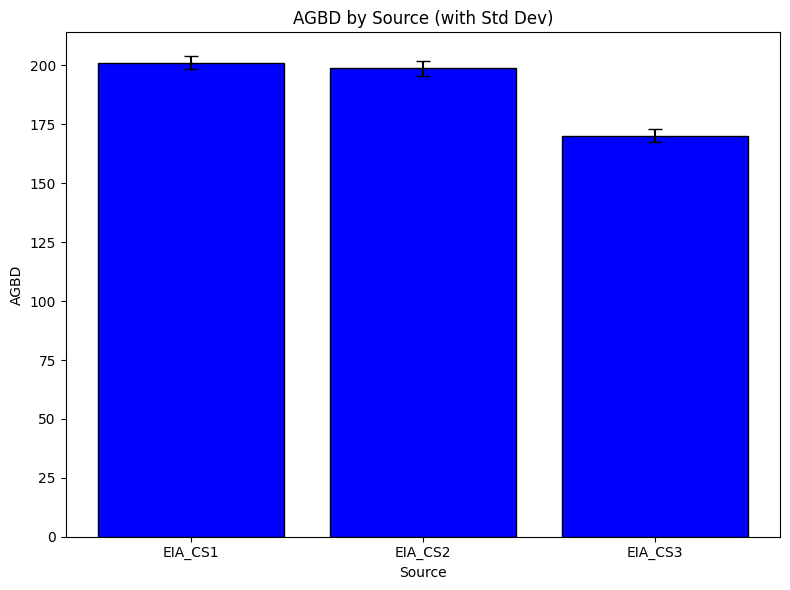

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Bar plot with error bars
plt.bar(
    combined_df_append["Source"],
    combined_df_append["AGBD"],
    yerr=combined_df_append["stdAGBD"],  # <-- add std deviation here
    capsize=5,                           # adds "caps" to the error bars
    color="blue",
    edgecolor="black"
)

plt.xlabel("Source")
plt.ylabel("AGBD")
plt.title("AGBD by Source (with Std Dev)")
plt.tight_layout()
plt.show()


In [39]:
combined_df_append

,AGBD,area,asset_version,stdAGBD,use_calibration,year,Source,Method,area_acres,agb_per_acre,std_agb_per_acre
0,201.254541,5.152478e+06,1.0,2.620774,True,2019,EIA_CS1,OBIWAN,1273.203945,0.158069,0.002058
1,198.777097,1.082126e+07,1.0,3.037097,True,2019,EIA_CS2,OBIWAN,2673.989052,0.074337,0.001136
2,170.233926,4.160505e+06,1.0,2.867049,True,2019,EIA_CS3,OBIWAN,1028.082356,0.165584,0.002789


Cross compare

In [41]:
esa_df = gdf
obiwan_df = combined_df_append

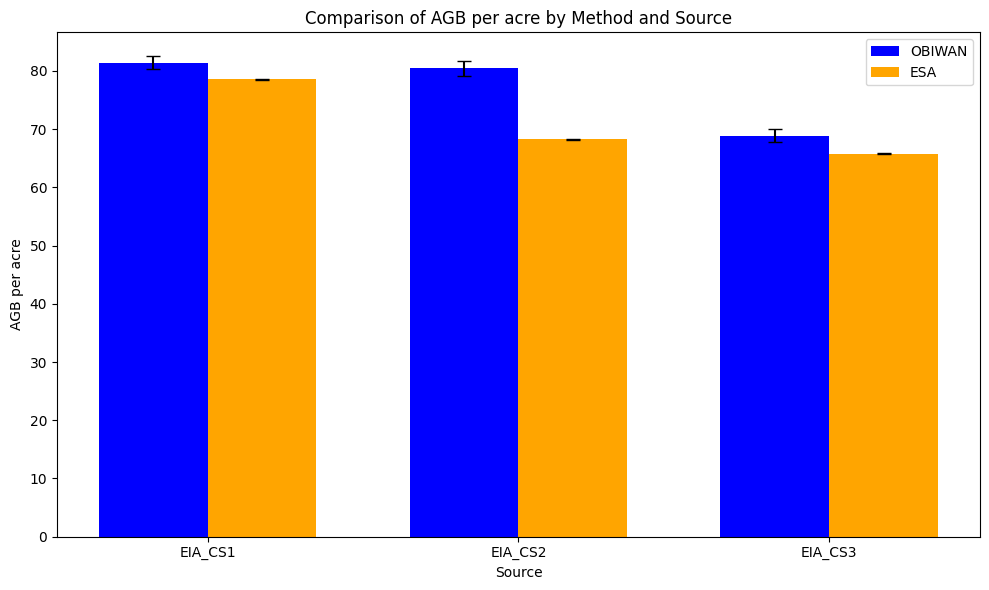

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# First, ensure column names match
obiwan_df['Source'] = obiwan_df['Source'].astype(str)
esa_df['Source'] = esa_df['Source'].astype(str)

# Prepare data for plotting
obiwan_plot = obiwan_df[['Source', 'agb_per_acre', 'std_agb_per_acre']]
esa_plot = esa_df[['Source', 'agb_per_acre', 'stdDev_AGB_per_acre']].rename(columns={'stdDev_AGB_per_acre':'std_agb_per_acre'})

# Add a column to identify the method
obiwan_plot['Method'] = 'OBIWAN'
esa_plot['Method'] = 'ESA'

# Combine both datasets
plot_df = pd.concat([obiwan_plot, esa_plot], axis=0)

# Pivot for plotting grouped bars
plot_pivot = plot_df.pivot(index='Source', columns='Method', values=['agb_per_acre','std_agb_per_acre'])
plot_pivot = plot_pivot.sort_index()  # optional, ensures sources are in order

# Plotting
sources = plot_pivot.index
x = np.arange(len(sources))  # the label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(10,6))

# Obiwan bars
ax.bar(x - width/2, plot_pivot['agb_per_acre']['OBIWAN'], width, yerr=plot_pivot['std_agb_per_acre']['OBIWAN'],
       capsize=5, label='OBIWAN', color='blue')

# ESA bars
ax.bar(x + width/2, plot_pivot['agb_per_acre']['ESA'], width, yerr=plot_pivot['std_agb_per_acre']['ESA'],
       capsize=5, label='ESA', color='orange')

# Labels and title
ax.set_xlabel('Source')
ax.set_ylabel('AGB per acre')
ax.set_title('Comparison of AGB per acre by Method and Source')
ax.set_xticks(x)
ax.set_xticklabels(sources)
ax.legend()

plt.tight_layout()
plt.show()


In [45]:
plot_df

,Source,agb_per_acre,std_agb_per_acre,Method
0,EIA_CS1,81.444949,1.060591,OBIWAN
1,EIA_CS2,80.442362,1.229071,OBIWAN
2,EIA_CS3,68.891332,1.160256,OBIWAN
0,EIA_CS1,78.533213,0.055407,ESA
1,EIA_CS2,68.227288,0.021973,ESA
2,EIA_CS3,65.785482,0.082459,ESA
